# Understanding Antibiotic Resistance Patterns: A Data-Driven Exploration

Antibiotic resistance is one of the most urgent challenges in modern healthcare.  
Despite continuous progress in drug development, bacteria evolve even faster — learning to survive treatments that once worked flawlessly. In this context, **data-driven surveillance** becomes essential for understanding how resistance emerges, spreads, and impacts patients.

In this project, I explore a synthetic dataset that simulates patient records and bacterial susceptibility results. The goal is to identify meaningful relationships between **demographics**, **infection frequency**, and **resistance profiles** — and to understand whether factors like age, gender, or comorbidities influence the severity or recurrence of infections.

To approach this systematically, the analysis follows a structured EDA workflow:

1. **Data Cleaning & Preparation**  
   Handling missing values, fixing inconsistencies, and extracting key attributes such as `Age`, `Gender`, and geographic information from unstructured fields.

2. **Demographic Exploration**  
   Understanding how infections vary across age groups, genders, and geographic regions to identify population-level patterns.

3. **Temporal & Geographic Trends**  
   Visualizing how infections evolve through time and how they distribute across different U.S. states using faceted charts and choropleth maps.

4. **Bacterial & Antibiotic Behavior**  
   Identifying the most common bacterial species, comparing infection severity, and analyzing resistance patterns across multiple antibiotics.

Each of these steps is supported by visual analysis and interpretative commentary, linking raw data to meaningful clinical and epidemiological considerations.

> **Objective**  
> Provide a clear, data-centric view of antibiotic resistance — not as a replacement for clinical research, but as a demonstration of how exploratory analytics can support evidence-based reasoning and generate new hypotheses.

In the next sections, we’ll transition from broad demographic insights to deeper questions about bacterial behavior and antibiotic response — concluding with a resistance heatmap that highlights the overall resistance landscape across organisms and drugs.

## 1. Setup & Imports
I use Pandas for data handling, Plotly for interactive charts, and scikit‑learn for the ML pipeline.

In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


pd.set_option('display.max_colwidth', 120)



## 2. Load Dataset

In [147]:
!kaggle datasets download -d adilimadeddinehosni/multi-resistance-antibiotic-susceptibility -p ./data
!unzip -o ./data/multi-resistance-antibiotic-susceptibility.zip -d ./data

pd.set_option('display.max_columns', None)
df = pd.read_csv('data/Bacteria_dataset_Multiresistance.csv')

df.head(4)

Dataset URL: https://www.kaggle.com/datasets/adilimadeddinehosni/multi-resistance-antibiotic-susceptibility
License(s): CC-BY-NC-SA-4.0
multi-resistance-antibiotic-susceptibility.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./data/multi-resistance-antibiotic-susceptibility.zip
  inflating: ./data/Bacteria_dataset_Multiresictance.csv  


,ID,Name,Email,Address,age/gender,Souches,Diabetes,Hypertension,Hospital_before,Infection_Freq,AMX/AMP,AMC,CZ,FOX,CTX/CRO,IPM,GEN,AN,Acide nalidixique,ofx,CIP,C,Co-trimoxazole,Furanes,colistine,Collection_Date,Notes
0,S290,Elizabeth Lawrence,elizabeth.lawrence@example.com,"6350 Robinson Loaf Apt. 447, Paulfurt, RI 30252",37/F,S290 Escherichia coli,No,No,No,0.0,R,R,R,R,R,R,S,S,S,S,S,R,S,S,S,5 Fev 2025,Patient had fever??
1,S291,Tina Sanders,tina.sanders@example.com,"78594 Galloway Port Suite 762, South Tanyatown, HI 30310",29/F,S291 Morganella morganii,True,No,No,3.0,S,R,S,R,S,R,S,S,S,S,S,S,S,S,S,08/05/2021,تم العلاج
2,S292,Erin Cooke,erin.cooke@example.com,"76661 Isaiah Manors, North Benjamin, HI 85195",77/F,S292 Proteus mirabilis,True,No,No,3.0,S,R,S,R,S,S,S,S,S,S,R,R,S,S,S,01/05/2022,NADA
3,S293,Mrs. Sharon Watson,mrs..sharon.watson@example.com,"1670 Thompson Way Apt. 520, Andrewbury, IL 11534",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-05,PACIENTO ENFERMO


In [148]:
dictionary = pd.read_csv('data/columns_dictionary.csv')
dictionary

,Column_Name,Description
0,ID,Unique patient or bacterial sample identifier
1,Name,Full name of the patient
2,Email,Patient contact email
3,Address,Complete address before parsing
4,age/gender,"Original combined field for age and gender (e.g. ""40/F"")"
5,Souches,Raw bacterial strain code
6,Diabetes,Indicates if the patient has diabetes
7,Hypertension,Indicates if the patient has hypertension
8,Hospital_before,Whether the patient was previously hospitalized
9,Infection_Freq,Frequency of infection episodes


## 3. Data Overview & Quality Checks
Basic structure, missingness, and categorical cardinality.

In [149]:
#get basic dataframe info
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Data types:\n", df.dtypes)

#review missing values
print("Missing values per column:\n",)
df.isnull().sum().sort_values(ascending=False)

Dataset shape: (10710, 27)
Columns: ['ID', 'Name', 'Email', 'Address', 'age/gender', 'Souches', 'Diabetes', 'Hypertension', 'Hospital_before', 'Infection_Freq', 'AMX/AMP', 'AMC', 'CZ', 'FOX', 'CTX/CRO', 'IPM', 'GEN', 'AN', 'Acide nalidixique', 'ofx', 'CIP', 'C', 'Co-trimoxazole', 'Furanes', 'colistine', 'Collection_Date', 'Notes']
Data types:
 ID                   object
Name                 object
Email                object
Address              object
age/gender           object
Souches              object
Diabetes             object
Hypertension         object
Hospital_before      object
Infection_Freq       object
AMX/AMP              object
AMC                  object
CZ                   object
FOX                  object
CTX/CRO              object
IPM                  object
GEN                  object
AN                   object
Acide nalidixique    object
ofx                  object
CIP                  object
C                    object
Co-trimoxazole       object
Furanes   

Collection_Date      669
AMX/AMP              658
GEN                  643
Souches              640
Co-trimoxazole       640
Infection_Freq       639
Hospital_before      637
Furanes              637
colistine            636
Diabetes             635
IPM                  633
CIP                  633
AMC                  632
Hypertension         630
C                    629
CZ                   628
AN                   628
FOX                  625
CTX/CRO              624
Acide nalidixique    622
age/gender           621
ofx                  618
Notes                112
Name                   0
Address                0
Email                  0
ID                     0
dtype: int64

### 4. Clean - Data Wrangling

In [150]:
# Extact city and state from addess column
df[['street', 'city', 'state', 'zip']] = df['Address'].str.extract(
    r'^(.*?),\s*(?:([A-Za-z\s]+|FPO|APO|DPO)\s+)?([A-Z]{2})\s*(\d{5})$'
)

# Extract Souche_ID and Souche_description
df[['Souche_ID', 'Souche_description']] = df['Souches'].str.extract(r'^(S?\d+)\s+(.*)$')


In [151]:
# Verify Collection_Date format, how many unique values are there?
df['Collection_Date'].value_counts()

Collection_Date
2024-12-31    1461
2020-01-05    1337
08/05/2021     719
5 Fev 2025     712
05/01/2025     708
05/03/2022     696
2020-12-31     693
2023-12-31     693
01/05/2022     692
3 Jan 1019     684
?              603
missing        535
error          508
Name: count, dtype: int64

In [152]:
# It is reasonable to assume that '3 Jan 1019' is a typo and should be '3 Jan 2019'
df['Collection_Date'] = df['Collection_Date'].replace({'3 Jan 1019': '3 Jan 2019'})

# Clean and convert Collection_Date to datetime
df['Collection_Date'] = df['Collection_Date'].astype(str).str.strip()
df['Collection_Date'] = df['Collection_Date'].replace(['?', 'missing', 'error'], None)
df['Collection_Date'] = pd.to_datetime(df['Collection_Date'], errors='coerce', dayfirst=True)

# Verify Collection_Date format, how many unique values are there?
df['Collection_Date'].value_counts()

/var/folders/sn/xrsxvpkj4bx6b_6m3_7zbjz80000gn/T/ipykernel_83443/411393144.py:7: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



Collection_Date
2024-12-31    1461
2020-01-05    1337
2021-05-08     719
2025-01-05     708
2022-03-05     696
2020-12-31     693
2023-12-31     693
2022-05-01     692
2019-01-03     684
Name: count, dtype: int64

In [153]:
# Check rows with missing state
df[df['state'].isna()][['Address', 'street', 'city', 'state', 'zip']].count()

Address    0
street     0
city       0
state      0
zip        0
dtype: int64

In [154]:
# Extract Age and Gender
df[['Age', 'Gender']] = df['age/gender'].str.extract(r'(\d+)\s*/?\s*([MF])?', expand=True)

# Convert age to numeric, coercing errors to NaN
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Fill missing gender values with NaN
df['Gender'] = df['Gender'].replace('', np.nan)

df.head(4)

,ID,Name,Email,Address,age/gender,Souches,Diabetes,Hypertension,Hospital_before,Infection_Freq,AMX/AMP,AMC,CZ,FOX,CTX/CRO,IPM,GEN,AN,Acide nalidixique,ofx,CIP,C,Co-trimoxazole,Furanes,colistine,Collection_Date,Notes,street,city,state,zip,Souche_ID,Souche_description,Age,Gender
0,S290,Elizabeth Lawrence,elizabeth.lawrence@example.com,"6350 Robinson Loaf Apt. 447, Paulfurt, RI 30252",37/F,S290 Escherichia coli,No,No,No,0.0,R,R,R,R,R,R,S,S,S,S,S,R,S,S,S,NaT,Patient had fever??,"6350 Robinson Loaf Apt. 447, Paulfurt",NaN,RI,30252,S290,Escherichia coli,37.0,F
1,S291,Tina Sanders,tina.sanders@example.com,"78594 Galloway Port Suite 762, South Tanyatown, HI 30310",29/F,S291 Morganella morganii,True,No,No,3.0,S,R,S,R,S,R,S,S,S,S,S,S,S,S,S,2021-05-08,تم العلاج,"78594 Galloway Port Suite 762, South Tanyatown",NaN,HI,30310,S291,Morganella morganii,29.0,F
2,S292,Erin Cooke,erin.cooke@example.com,"76661 Isaiah Manors, North Benjamin, HI 85195",77/F,S292 Proteus mirabilis,True,No,No,3.0,S,R,S,R,S,S,S,S,S,S,R,R,S,S,S,2022-05-01,NADA,"76661 Isaiah Manors, North Benjamin",NaN,HI,85195,S292,Proteus mirabilis,77.0,F
3,S293,Mrs. Sharon Watson,mrs..sharon.watson@example.com,"1670 Thompson Way Apt. 520, Andrewbury, IL 11534",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-05,PACIENTO ENFERMO,"1670 Thompson Way Apt. 520, Andrewbury",NaN,IL,11534,NaN,NaN,NaN,NaN


In [155]:
# assign gender according to first names
male_names = {
    'Aaron','Abdullah','Adam','Adriano','Adrian','Ahmad','Alain','Alan','Albert','Alberto','Aldo','Alec',
    'Alejandro','Alessandro','Alex','Alexander','Alexandre','Alfonso','Alfred','Alfredo','Ali','Amedeo',
    'Amir','Anders','Andoni','Andre','Andrea','Andreas','Andrew','Andrey','Andy','Angel','Angelo','Anthony',
    'Antonio','Antoine','Anton','Antonio','Armand','Arnaud','Arnold','Arthur','Arturo','Augusto','Austin',
    'Barry','Ben','Benjamin','Bernard','Bill','Billy','Boris','Brad','Brandon','Brian','Bruno','Bryan','Caleb',
    'Carl','Carlos','Carlo','Carmelo','Casper','Cédric','Cesare','Charles','Charlie','Chris','Christian',
    'Christopher','Claude','Claudio','Colin','Connor','Craig','Cristian','Cristiano','Curtis','Damian',
    'Daniel','Danny','Dario','Darren','David','Davide','Dean','Dennis','Derek','Diego','Dimitri','Dominic',
    'Donald','Douglas','Dylan','Edoardo','Edouard','Eduardo','Edward','Edwin','Elias','Elio','Eliseo','Emanuele',
    'Emilio','Emmanuel','Enrico','Enrique','Eric','Erik','Erin','Ernesto','Ethan','Ettore','Eugenio','Eusebio','Fabian',
    'Fabio','Federico','Felipe','Felix','Fernando','Filippo','Flavio','Francesco','Francis','Francisco','Frank',
    'Franco','Fred','Frederic','Frederick','Gabriel','Gael','Gabriele','Gaston','Gavin','Geoffrey','George',
    'Gerald','Germain','Giacomo','Gianluca','Gino','Giovanni','Giuseppe','Giulio','Glen','Gordon','Greg',
    'Gregory','Guido','Guillaume','Guillermo','Gustavo','Hector','Henry','Hugo','Ian','Ibrahim','Igor','Isaac',
    'Ismael','Ivan','Jack','Jacob','Jake','James','Jamie','Jason','Jean','Jeff','Jeffrey','Jerome','Jerry',
    'Jesse','Jesus','Jim','Jimmy','Joe','Joel','John','Johnny','Jonathan','Jordan','Jorge','Jose','Joseph',
    'Josh','Joshua','Juan','Julian','Julien','Justin','Karl','Kevin','Khaled','Kieran','Landon','Larry','Laurent',
    'Lawrence','Leo','Leon','Leonard','Leonardo','Liam','Lorenzo','Louis','Luc','Luca','Lucas','Luciano',
    'Luigi','Luis','Luka','Luke','Manuel','Marc','Marcel','Marco','Marcus','Mario','Mark','Martin','Marvin',
    'Massimo','Matteo','Matthew','Maurice','Maurizio','Max','Maximilian','Michael','Michele','Miguel','Mike',
    'Mirko','Mohamed','Mohammed','Nadir','Nathan','Nicholas','Nicolas','Nico','Nigel','Noah','Norbert','Olivier',
    'Oscar','Pablo','Paolo','Patrick','Paul','Pedro','Pietro','Pierre','Rafael','Raimondo','Ralph','Ramon',
    'Raul','Raymond','Remy','Renato','Ricardo','Richard','Rick','Robert','Roberto','Rodrigo','Roger','Roland',
    'Romain','Roman','Romeo','Ronald','Ruben','Russell','Ryan','Salvatore','Sam','Samuel','Sandro','Scott',
    'Sean','Sebastian','Serge','Sergio','Simone','Stefano','Stephen','Steve','Steven','Sylvain','Sylvester',
    'Taylor','Terry','Theo','Theodore','Thomas','Tim','Timothy','Todd','Tom','Tomas','Tony','Tristan','Troy',
    'Tyler','Valentino','Valerio','Victor','Vincent','Vincenzo','Vittorio','Walter','Wayne','William','Xavier',
    'Yann','Youssef','Yuri','Zachary','Kenneth','Jeremy','Dawn','Shawn','Kyle','Keith','Dustin','Gary','Randy',
    'Jared','Kristin','Phillip','Tara','Rodney','Morgan','Courtney','Shane','Cameron','Curt','Allan','Dale','Derrick','Shawn','Lance','Ernest','Cory',
    'Shawn','Calvin','Jonathon','Mitchell','Rolando','Edgar','Edmund','Felton','Garrett','Hubert','Jimmie',
    'Lyle','Mack','Marion','Marty','Nathaniel','Neal','Oliver','Randall','Rickey','Robbie','Roberto','Salvador','Sammy','Terry','Timmy',
    'Alexis','Brett','Daryl','Devon','Drew','Jody','Kurt','Loren','Lorenzo','Malcolm','Marcel','Marquis',
    'Micheal','Mickey','Milan','Morris','Nickolas','Orville','Perry','Ricky','Robb','Rocky','Seth','Stuart','Tracy',
    'Trenton','Tyson','Wade','Warren','Wesley','Peter','Robin','Cody', 'Philip', 'Ann', 'Jeffery', 'Jay',
    'Travis', 'Chad', 'Corey', 'Bruce'
}

female_names = {
    'Abigail','Ada','Adriana','Adrienne','Agata','Agnes','Alba','Alessandra','Alexa','Alexandra','Alexandria',
    'Alexia','Alice','Alicia','Alison','Alma','Alyssa','Amanda','Amelia','Amy','Ana','Anastasia','Andrea',
    'Angela','Angelica','Angelina','Anita','Anna','Annabelle','Anne','Annette','Annie','Antonella','Antonia',
    'April','Ariana','Arianna','Ariel','Ashley','Aurora','Barbara','Beatrice','Belinda','Benedetta','Bernadette',
    'Beth','Bianca','Bonnie','Brenda','Briana','Brianna','Brittany','Camila','Candice','Carla','Carlotta','Carmen',
    'Carolina','Caroline','Cassandra','Catherine','Cecilia','Celeste','Charlotte','Chelsea','Christina',
    'Christine','Claire','Clara','Claudia','Colleen','Connie','Cynthia','Cristina','Daisy','Dana','Daniela',
    'Danielle','Debbie','Deborah','Denise','Diana','Diane','Dominique','Donna','Dorothy','Elena','Eliana',
    'Elisa','Elisabeth','Elise','Eliza','Elizabeth','Ella','Ellen','Elsa','Emanuela','Emilia','Emily',
    'Emma','Erica','Erika','Esmeralda','Estelle','Esther','Evelyn','Fabiana','Faith','Federica','Felicia',
    'Fiona','Flavia','Florence','Frances','Francesca','Gabriela','Gabriella','Georgia','Giada','Gina',
    'Ginevra','Giovanna','Gloria','Grace','Greta','Hannah','Heather','Helen','Helena','Ilaria','Imelda',
    'Ines','Ingrid','Irene','Isabel','Isabella','Isabelle','Jacqueline','Jade','Jamie','Jane','Janet',
    'Janice','Jasmine','Jean','Jeanette','Jennifer','Jessica','Jill','Joan','Joanna','Joanne','Jodie',
    'Jordan','Josephine','Joy','Joyce','Julia','Julie','Juliette','June','Karen','Kate','Katherine','Kathleen',
    'Kathryn','Katrina','Kayla','Kelly','Kim','Kimberly','Kristen','Kristina','Krystal','Laura','Lauren','Lea','Leah',
    'Lena','Letizia','Lidia','Lila','Lili','Liliana','Lillian','Lily','Linda','Lisa','Lorena','Lorraine',
    'Louise','Lucia','Lucy','Luisa','Luna','Lydia','Maddalena','Madeline','Madison','Mae','Maggie','Manuela',
    'Marcella','Margaret','Maria','Mariah','Mariam','Mariana','Marianne','Marie','Marina','Marisa','Marta',
    'Martha','Mary','Matilde','Megan','Melanie','Melissa','Mercedes','Mia','Michelle','Mila','Milena',
    'Mirella','Miriana','Miriam','Monica','Nadia','Nancy','Naomi','Natalia','Natalie','Nicole','Nina',
    'Noemi','Olga','Olivia','Paola','Patricia','Patrizia','Paula','Paulina','Penelope','Piera','Rachel',
    'Rebecca','Rita','Roberta','Rosa','Rosalia','Rosalinda','Rose','Rosella','Rossella','Sabrina','Samantha',
    'Sandra','Sara','Sarah','Savannah','Selena','Serena','Sharon','Sheila','Silvia','Simona','Sofia','Sonia',
    'Sophia','Sophie','Stacy','Stella','Stephanie','Stefania','Susan','Susanna','Suzanne','Sylvia','Teresa',
    'Tiffany','Tina','Valentina','Valeria','Vanessa','Veronica','Victoria','Vincenza','Virginia','Viviana','Vivienne',
    'Whitney','Yolanda','Yvette','Zoe','Crystal','Lory','Tammy','Shannon','Cheryl','Amber','Lori','Holly','Wendy'',Carol',
    'Cindy','Rhonda','Allison','Renee','Lindsey','Theresa','Bradley','Wendy','Carol','Shane','Debra','Regina',
    'Kathy','Katie','Carolyn','Sherry','Carrie','Tanya','Shelly','Brandy','Brandi','Jill','Erika','Tracy',
    'Jenna','Kara','Kristy','Melinda','Leah','Misty','Shelley','Sonya','Tonya','Christy','Jeanne','Angie',
    'Faye','Jocelyn','Kelli','Lana','Lora','Marsha','Nina','Priscilla','Rachael','Stacie','Trina','Vanessa','Heidi',
    'Pamela','Tamara', 'Valerie', 'Brooke','Natasha', 'Laurie','Krista','Leslie', 'Kelsey'
}

def infer_gender(name):
    if pd.isna(name):
        return None
    name_clean = str(name).strip().title()
    if name_clean in male_names:
        return 'M'
    elif name_clean in female_names:
        return 'F'
    else:
        return None 
    
    # Name and Surname extraction
df[['First_Name', 'Surname']] = df['Name'].str.extract(r'^(\S+)\s+(.+)$')

# Save first name counts to CSV and inspect manually
a = df['First_Name'].value_counts().to_csv('data/first_name_counts.csv')


df['Gender'] = df['First_Name'].apply(infer_gender)
df.head(10)


,ID,Name,Email,Address,age/gender,Souches,Diabetes,Hypertension,Hospital_before,Infection_Freq,AMX/AMP,AMC,CZ,FOX,CTX/CRO,IPM,GEN,AN,Acide nalidixique,ofx,CIP,C,Co-trimoxazole,Furanes,colistine,Collection_Date,Notes,street,city,state,zip,Souche_ID,Souche_description,Age,Gender,First_Name,Surname
0,S290,Elizabeth Lawrence,elizabeth.lawrence@example.com,"6350 Robinson Loaf Apt. 447, Paulfurt, RI 30252",37/F,S290 Escherichia coli,No,No,No,0.0,R,R,R,R,R,R,S,S,S,S,S,R,S,S,S,NaT,Patient had fever??,"6350 Robinson Loaf Apt. 447, Paulfurt",NaN,RI,30252,S290,Escherichia coli,37.0,F,Elizabeth,Lawrence
1,S291,Tina Sanders,tina.sanders@example.com,"78594 Galloway Port Suite 762, South Tanyatown, HI 30310",29/F,S291 Morganella morganii,True,No,No,3.0,S,R,S,R,S,R,S,S,S,S,S,S,S,S,S,2021-05-08,تم العلاج,"78594 Galloway Port Suite 762, South Tanyatown",NaN,HI,30310,S291,Morganella morganii,29.0,F,Tina,Sanders
2,S292,Erin Cooke,erin.cooke@example.com,"76661 Isaiah Manors, North Benjamin, HI 85195",77/F,S292 Proteus mirabilis,True,No,No,3.0,S,R,S,R,S,S,S,S,S,S,R,R,S,S,S,2022-05-01,NADA,"76661 Isaiah Manors, North Benjamin",NaN,HI,85195,S292,Proteus mirabilis,77.0,M,Erin,Cooke
3,S293,Mrs. Sharon Watson,mrs..sharon.watson@example.com,"1670 Thompson Way Apt. 520, Andrewbury, IL 11534",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-05,PACIENTO ENFERMO,"1670 Thompson Way Apt. 520, Andrewbury",NaN,IL,11534,NaN,NaN,NaN,None,Mrs.,Sharon Watson
4,S294,Erika Stewart,erika.stewart@example.com,"76838 Patrick Green Suite 538, Torresmouth, ME 50811",13/F,S294 Escherichia coli,No,Yes,No,1.0,S,S,R,R,R,R,R,R,S,S,S,S,S,S,S,NaT,NADA,"76838 Patrick Green Suite 538, Torresmouth",NaN,ME,50811,S294,Escherichia coli,13.0,F,Erika,Stewart
5,S295,Krystal Riley,krystal.riley@example.com,"USNS Neal, FPO AA 98816",57/M,S295 Escherichia coli,True,No,No,3.0,R,S,R,R,S,S,S,R,S,S,S,S,S,S,S,2020-01-05,Patient had fever??,USNS Neal,FPO,AA,98816,S295,Escherichia coli,57.0,F,Krystal,Riley
6,S296,Gina Griffin,gina.griffin@example.com,"389 Ferguson Island, West Jefferymouth, MT 89882",68/F,S296 Escherichia coli,No,No,No,3.0,R,R,R,R,R,S,R,S,S,S,S,S,S,S,S,2020-12-31,see file,"389 Ferguson Island, West Jefferymouth",NaN,MT,89882,S296,Escherichia coli,68.0,F,Gina,Griffin
7,S297,Faith Newman,faith.newman@example.com,"256 Bartlett Fork Suite 334, East Sherri, MI 97936",18/F,S297 Citrobacter spp.,No,No,No,2.0,R,R,R,R,R,S,S,S,S,S,S,S,R,S,S,2022-03-05,تم العلاج,"256 Bartlett Fork Suite 334, East Sherri",NaN,MI,97936,S297,Citrobacter spp.,18.0,F,Faith,Newman
8,S298,Russell Hicks,russell.hicks@example.com,"77940 Richard Brook Apt. 748, South Jessica, GA 59614",77/F,S298 Enterobacteria spp.,No,No,No,0.0,S,S,R,R,R,R,S,S,S,S,S,S,S,S,S,2025-01-05,MALADIE GRAVE,"77940 Richard Brook Apt. 748, South Jessica",NaN,GA,59614,S298,Enterobacteria spp.,77.0,M,Russell,Hicks
9,S299,Kimberly Rodriguez,kimberly.rodriguez@example.com,"1979 Kayla Squares Suite 125, West Cynthia, MO 13672",36/F,S299 Proeus mirabilis,No,No,No,3.0,R,R,R,R,S,S,S,S,R,S,S,S,S,S,S,2021-05-08,Patient had fever??,"1979 Kayla Squares Suite 125, West Cynthia",NaN,MO,13672,S299,Proeus mirabilis,36.0,F,Kimberly,Rodriguez


In [156]:
# Evaluate percentage of names with assigned gender
coverage = df['Gender'].notna().mean() * 100
print(f"✅ Gender assigned to {coverage:.1f}% of names.")

✅ Gender assigned to 89.7% of names.


In [157]:
# check names with missing gender
counts = df[df['Gender'].isna()]['First_Name'].value_counts()

# selct names with more than 10 occurrences
common_names = counts[counts > 10].index
common_names

Index(['Mr.', 'Dr.', 'Mrs.', 'Ms.'], dtype='object', name='First_Name')

In [158]:
# drop rows without gender
df = df[df['Gender'].notna()]
df.columns = df.columns.str.strip().str.lower()

In [159]:
# filter invalid values in diabetes and infection_freq columns
df = df[df['diabetes'].isin(['True', 'No'])]

# filter invalid values in infection_freq column
df = df[~df['infection_freq'].isin(['unknown', 'error', 'missing'])]

# Normalize souce_description text

df['souche_description'] = (
    df['souche_description']
    .str.lower()
    .replace(
        {
            'e coli': 'escherichia coli',
            'e.coi': 'escherichia coli',
            'e.cli': 'escherichia coli',
            'e. coli': 'escherichia coli',
            'spp. enteobacteria spp.':'enterobacteria spp.',
            'enter.bacteria': 'enterobacteria spp.',
            'klbsiella pneumoniae':'klebsiella pneumoniae',
            'klebsie.lla pneumoniae': 'klebsiella pneumoniae',
            'protus mirabilis': 'proteus mirabilis',
            'prot.eus mirabilis':'proteus mirabilis',
            'proeus mirabilis': 'proteus mirabilis',
            'enteobacteria spp.':   'enterobacteria spp.',
            'enter.bacteria spp.': 'enterobacteria spp.'
        }
    )
    .str.title()  # opzionale per ripristinare maiuscole estetiche
)

df['souche_description'].value_counts()


souche_description
Escherichia Coli           5352
Enterobacteria Spp.         883
Proteus Mirabilis           645
Klebsiella Pneumoniae       627
Citrobacter Spp.            417
Morganella Morganii         258
Serratia Marcescens         219
Pseudomonas Aeruginosa      170
Acinetobacter Baumannii     155
Name: count, dtype: int64

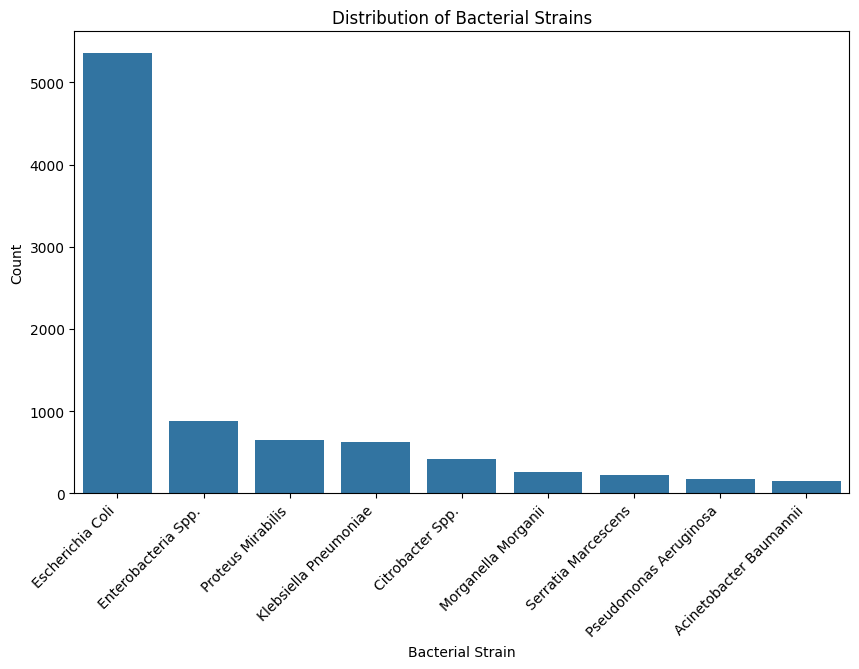

In [160]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='souche_description', order=df['souche_description'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Bacterial Strains')
plt.xlabel('Bacterial Strain')
plt.ylabel('Count')
plt.show()

In [161]:
# Map infection_freq to descriptive labels
df['infection_label'] = df['infection_freq'].map({
    '0.0': 'None',
    '1.0': 'Low',
    '2.0': 'Medium',
    '3.0': 'High'
})

df.head(4)

,id,name,email,address,age/gender,souches,diabetes,hypertension,hospital_before,infection_freq,amx/amp,amc,cz,fox,ctx/cro,ipm,gen,an,acide nalidixique,ofx,cip,c,co-trimoxazole,furanes,colistine,collection_date,notes,street,city,state,zip,souche_id,souche_description,age,gender,first_name,surname,infection_label
0,S290,Elizabeth Lawrence,elizabeth.lawrence@example.com,"6350 Robinson Loaf Apt. 447, Paulfurt, RI 30252",37/F,S290 Escherichia coli,No,No,No,0.0,R,R,R,R,R,R,S,S,S,S,S,R,S,S,S,NaT,Patient had fever??,"6350 Robinson Loaf Apt. 447, Paulfurt",NaN,RI,30252,S290,Escherichia Coli,37.0,F,Elizabeth,Lawrence,None
1,S291,Tina Sanders,tina.sanders@example.com,"78594 Galloway Port Suite 762, South Tanyatown, HI 30310",29/F,S291 Morganella morganii,True,No,No,3.0,S,R,S,R,S,R,S,S,S,S,S,S,S,S,S,2021-05-08,تم العلاج,"78594 Galloway Port Suite 762, South Tanyatown",NaN,HI,30310,S291,Morganella Morganii,29.0,F,Tina,Sanders,High
2,S292,Erin Cooke,erin.cooke@example.com,"76661 Isaiah Manors, North Benjamin, HI 85195",77/F,S292 Proteus mirabilis,True,No,No,3.0,S,R,S,R,S,S,S,S,S,S,R,R,S,S,S,2022-05-01,NADA,"76661 Isaiah Manors, North Benjamin",NaN,HI,85195,S292,Proteus Mirabilis,77.0,M,Erin,Cooke,High
4,S294,Erika Stewart,erika.stewart@example.com,"76838 Patrick Green Suite 538, Torresmouth, ME 50811",13/F,S294 Escherichia coli,No,Yes,No,1.0,S,S,R,R,R,R,R,R,S,S,S,S,S,S,S,NaT,NADA,"76838 Patrick Green Suite 538, Torresmouth",NaN,ME,50811,S294,Escherichia Coli,13.0,F,Erika,Stewart,Low


In [162]:
# create final dataframe for social demographic analysis
df_demo = df[['age', 'gender','collection_date','diabetes','hypertension','hospital_before','infection_freq','infection_label', 'souche_id', 'souche_description', 'state', 'zip']]

df_demo.head(10)

,age,gender,collection_date,diabetes,hypertension,hospital_before,infection_freq,infection_label,souche_id,souche_description,state,zip
0,37.0,F,NaT,No,No,No,0.0,None,S290,Escherichia Coli,RI,30252
1,29.0,F,2021-05-08,True,No,No,3.0,High,S291,Morganella Morganii,HI,30310
2,77.0,M,2022-05-01,True,No,No,3.0,High,S292,Proteus Mirabilis,HI,85195
4,13.0,F,NaT,No,Yes,No,1.0,Low,S294,Escherichia Coli,ME,50811
5,57.0,F,2020-01-05,True,No,No,3.0,High,S295,Escherichia Coli,AA,98816
6,68.0,F,2020-12-31,No,No,No,3.0,High,S296,Escherichia Coli,MT,89882
7,18.0,F,2022-03-05,No,No,No,2.0,Medium,S297,Citrobacter Spp.,MI,97936
8,77.0,M,2025-01-05,No,No,No,0.0,None,S298,Enterobacteria Spp.,GA,59614
9,36.0,F,2021-05-08,No,No,No,3.0,High,S299,Proteus Mirabilis,MO,13672
10,49.0,M,2023-12-31,True,No,Yes,2.0,Medium,S300,Escherichia Coli,VI,68443


In [163]:
# Count missing values
missing_counts = df_demo.isna().sum()

# Calculate percentage
missing_percent = (missing_counts / len(df)) * 100

# Combine into one DataFrame for readability
missing_summary = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_%': missing_percent
}).sort_values(by='Missing_%', ascending=False)

display(missing_summary)

,Missing_Count,Missing_%
collection_date,2313,26.506991
age,0,0.000000
gender,0,0.000000
diabetes,0,0.000000
hypertension,0,0.000000
hospital_before,0,0.000000
infection_freq,0,0.000000
infection_label,0,0.000000
souche_id,0,0.000000
souche_description,0,0.000000


In [164]:
# Summary statistics for age to verify min/max values
df_demo['age'].describe().astype(int)

count    8726
mean       45
std        24
min         0
25%        25
50%        45
75%        67
max        90
Name: age, dtype: int64

## 4. Exploratory Data Analysis
High‑level distributions and resistance patterns.


### 🧩 4.1 — How many patients in the dataset experienced no infection, one infection, or multiple infections?

**Approach:**  
The `infection_freq` variable describes the number of infection episodes reported per patient, ranging from 0 to 3.  
We categorized the population into four groups:
- **0.0** → Non-infected  
- **1.0** → Single infection  
- **2.0** → Double infection  
- **3.0** → Recurrent infections  

This allows us to visualize the infection frequency distribution across the dataset.


In [165]:
df_demo.groupby(['infection_freq'])['souche_description'].nunique()

infection_freq
0.0    9
1.0    9
2.0    9
3.0    9
Name: souche_description, dtype: int64

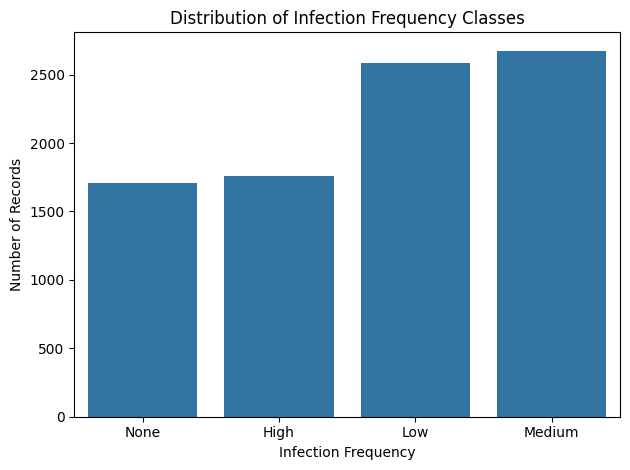

In [166]:
sns.countplot(
    data=df_demo,
    x='infection_label'
)
plt.title('Distribution of Infection Frequency Classes')
plt.xlabel('Infection Frequency')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()

**Observation:**  
The dataset shows an **equal number of samples (n = 9)** for each infection frequency level.  
This indicates that the data were likely **balanced intentionally**, rather than reflecting a natural clinical distribution.  
Thus, the dataset appears designed for **comparative modeling** or **classification tasks**, not for epidemiological prevalence analysis.

> 🔍 **Remark:**  
> Infection frequencies are uniformly distributed across four categories (0–3).  
> This balance suggests a controlled dataset, which is useful for modeling but limits direct real-world inference about infection prevalence.

### 4.2 Is there a relationship between patient age and infection frequency, or are infections evenly distributed across age groups?

**Approach:**  
I first explored the age distribution for each bacterial strain using boxplots and density plots to identify potential age-related trends.  
I then quantified the relationship between `Age` and `Infection_Freq` using Spearman correlation and ANOVA to assess whether the differences in age across bacterial strains are statistically significant.

**Visualization:**  
The boxplot below shows the age distribution for the main bacterial strains observed in the dataset.

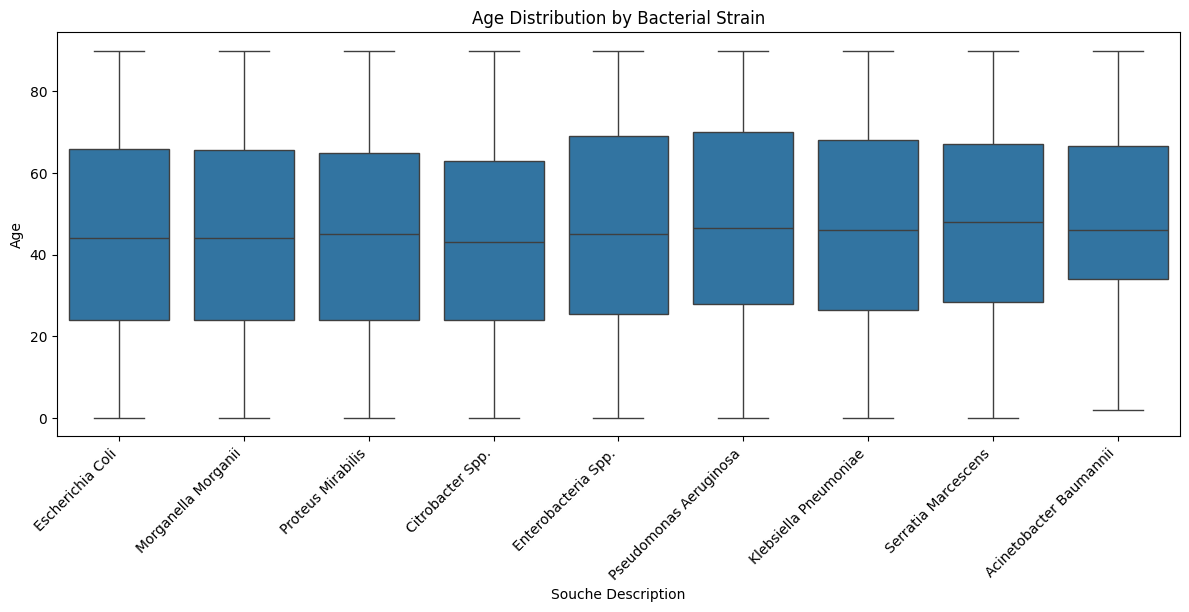

In [167]:
plt.figure(figsize=(12, 6))   # <-- imposti qui le dimensioni del canvas

sns.boxplot(data=df_demo, x='souche_description', y='age') 

plt.xticks(rotation=45, ha='right')  # ruota le etichette sull'asse X
plt.tight_layout()                   # ottimizza gli spazi
plt.xlabel('Souche Description')
plt.ylabel('Age')
plt.title('Age Distribution by Bacterial Strain')
plt.show()

In [168]:
# Calculate Spearman correlation between age and infection_freq

corr = df_demo[['age', 'infection_freq']].corr(method='spearman').iloc[0,1]
print(f"Spearman correlation (Age vs Infection_Freq): {corr:.3f}")

Spearman correlation (Age vs Infection_Freq): 0.007


In [169]:
from scipy.stats import f_oneway

# calculate ANOVA
groups = [group['age'].dropna().values for _, group in df_demo.groupby('souche_description')]
f_stat, p_value = f_oneway(*groups)

print(f"ANOVA F = {f_stat:.3f}, p = {p_value:.3e}")

ANOVA F = 1.275, p = 2.516e-01


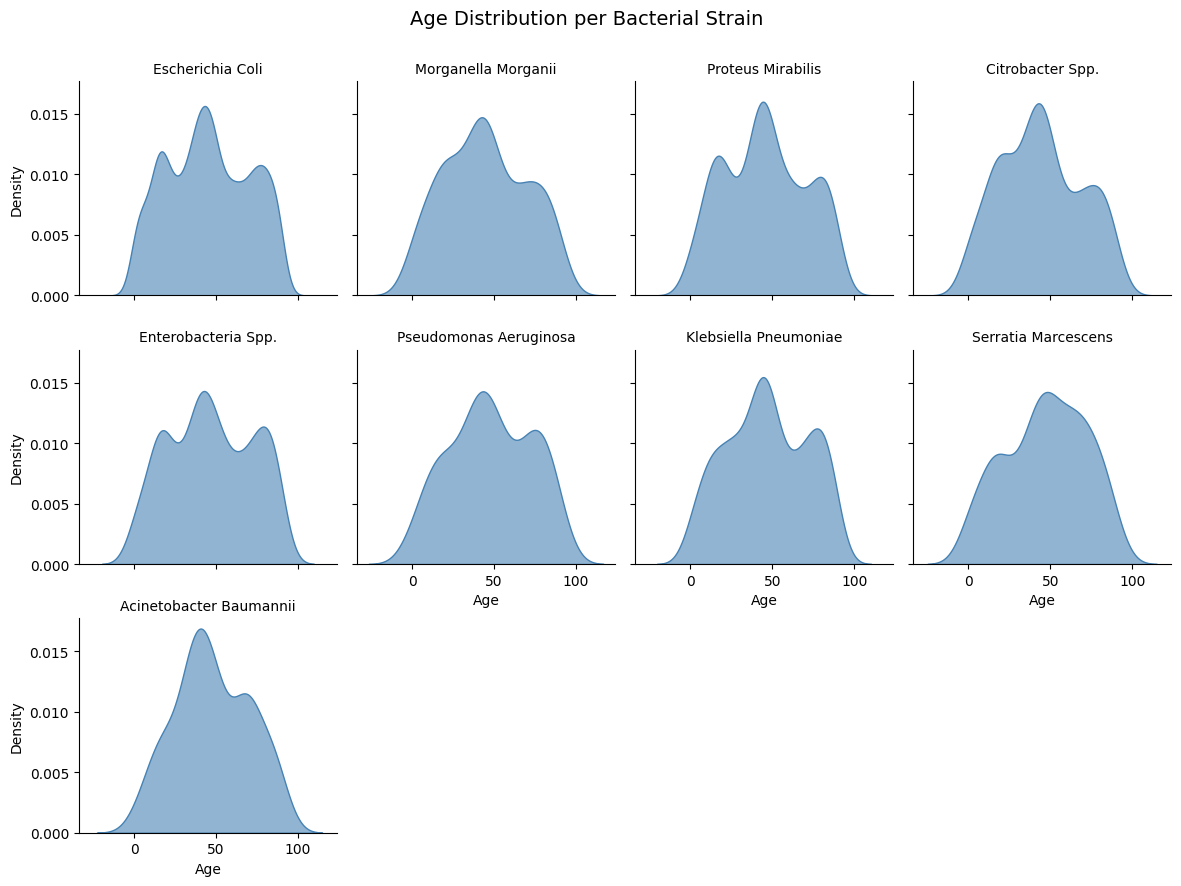

In [170]:
g = sns.FacetGrid(df_demo, col='souche_description', col_wrap=4, height=3, sharex=True, sharey=True)
g.map_dataframe(sns.kdeplot, x='age', fill=True, color='steelblue', alpha=0.6)
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Age', 'Density')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Age Distribution per Bacterial Strain', fontsize=14)
plt.show()

**Observation:**  
The median age appears to be similar across most bacterial strains, typically ranging between 40 and 50 years.  
The spread of ages is broad and comparable, indicating that infections occur across all age groups without a clear concentration in a specific demographic.

To validate this observation statistically, we computed:
- **Spearman correlation (Age vs Infection_Freq):** `0.007`  
  → Suggests virtually *no monotonic relationship* between age and infection frequency.
- **ANOVA F = 1.275**, **p = 0.2516**  
  → Confirms that *age distributions do not significantly differ* among bacterial strains (p > 0.05).



### 4.4 How have infection frequencies evolved over time, and do these temporal trends differ between male and female patients?

**Approach:**  
To explore temporal dynamics, infection records were grouped by year, bacterial strain (`souche_description`), and gender.  
We then visualized the number of infections per year using a FacetGrid of line plots — each subplot representing one bacterial strain, with separate lines for male and female patients.

**Visualization:**  
The chart below illustrates infection trends over time (2019–2025) for the main bacterial strains.

/var/folders/sn/xrsxvpkj4bx6b_6m3_7zbjz80000gn/T/ipykernel_83443/3969644417.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sn/xrsxvpkj4bx6b_6m3_7zbjz80000gn/T/ipykernel_83443/3969644417.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sn/xrsxvpkj4bx6b_6m3_7zbjz80000gn/T/ipykernel_83443/3969644417.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

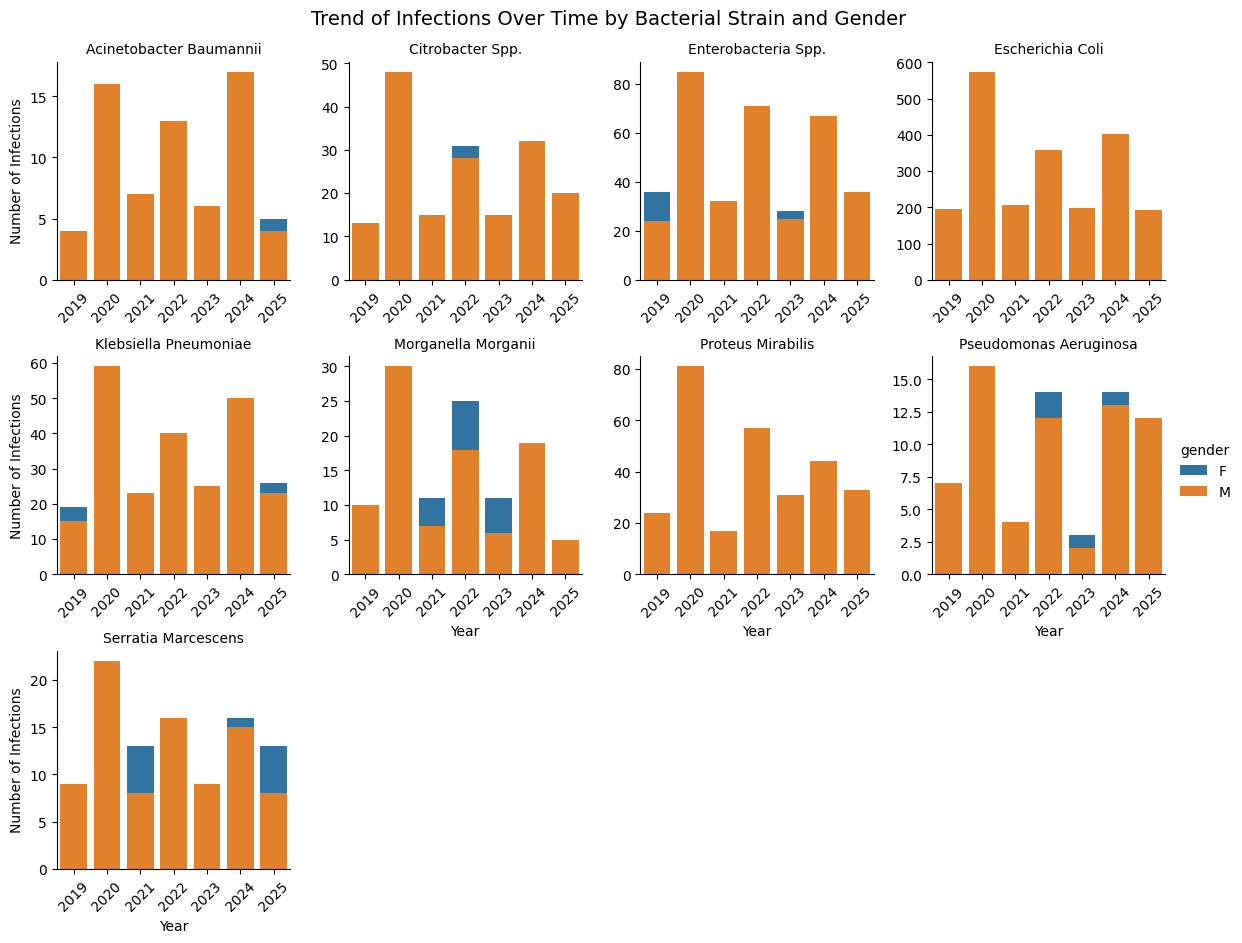

In [171]:
df_demo['year'] = df_demo['collection_date'].notna()
df_demo['year'] = df_demo['collection_date'].dt.year
df_demo = df_demo[df_demo['year'].notna()]
df_demo['year'] = df_demo['year'].astype(int)

infections_by_year_gender = (
    df_demo.groupby(['year', 'souche_description', 'gender'])
    .size()
    .reset_index(name='infection_count')
)

g = sns.FacetGrid(
    infections_by_year_gender,
    col='souche_description',
    col_wrap=4,
    height=3,
    sharex=False,
    sharey=False,
    hue='gender'
)
g.map_dataframe(sns.barplot, x='year', y='infection_count')
g.add_legend()
g.set_xticklabels(rotation=45)
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Year', 'Number of Infections')
plt.subplots_adjust(wspace=0.25, hspace=0.35)
g.fig.suptitle('Trend of Infections Over Time by Bacterial Strain and Gender', fontsize=14,y=1.02)
plt.show()

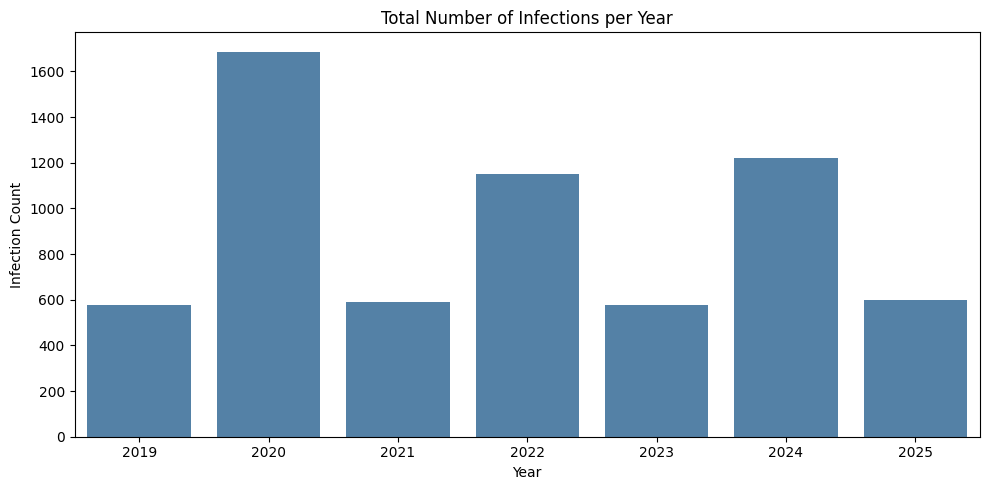

In [172]:
annual_trend = df_demo.groupby('year')['infection_freq'].count().reset_index(name='total_infections')

plt.figure(figsize=(10,5))
sns.barplot(data=annual_trend, x=annual_trend['year'].astype(int), y='total_infections', color='steelblue')
plt.title('Total Number of Infections per Year')
plt.xlabel('Year')
plt.ylabel('Infection Count')
plt.tight_layout()
plt.show()

In [173]:
import plotly.express as px

# Group by state
infections_by_state = (
    df_demo.groupby('state')
    .size()
    .reset_index(name='infection_count')
)

# Create a choropleth map
fig = px.choropleth(
    infections_by_state,
    locations='state',
    locationmode='USA-states',
    color='infection_count',
    color_continuous_scale='Blues',
    labels={'infection_count': 'Nr of Infections'},
    scope='usa',
    title='Geographic Distribution of Infections Across U.S. States'
)

fig.update_layout(
    geo=dict(bgcolor='rgba(0,0,0,0)'),
    margin=dict(l=0, r=0, t=50, b=0),
    title_x=0.5
)


fig.show()

#### **Observations**

- The choropleth visualization shows a **relatively uniform distribution** of infection counts across U.S. states, with no evident geographic clusters or outliers.  
- **No consistent regional patterns** (e.g., North–South or East–West differences) emerge from the data.  
- Slight variations in intensity appear **random and not epidemiologically meaningful**, likely reflecting data variability rather than true spatial trends.  
- When combined with previous analyses (age, gender, and infection frequency), these results further support the idea of a **homogeneous dataset** without clear demographic or territorial dependencies.  
- In summary, **infection incidence appears evenly distributed nationwide**, suggesting either balanced data collection or the absence of regional infection drivers in the available records.  

### 4.5 Are certain bacterial species more frequently associated with higher infection levels?

**Approach:**  
The dataset was grouped by `souche_description` and `infection_label` to evaluate how infection severity is distributed across bacterial strains.  
A grouped bar plot was generated, where each bar represents the number of cases for a specific bacterial strain, segmented by infection level (`Low`, `Medium`, `High`, `None`).

In [174]:
df_clean = df[['collection_date',
    'diabetes', 'hypertension', 'hospital_before', 'infection_freq', 'infection_label',
    'amx/amp', 'amc', 'cz', 'fox', 'ctx/cro', 'ipm', 'gen', 'an', 'acide nalidixique',
    'ofx', 'cip', 'c', 'co-trimoxazole', 'furanes', 'colistine',
    'collection_date', 'state', 'zip',
    'souche_id', 'souche_description', 'age', 'gender'
]]

df_clean

,collection_date,diabetes,hypertension,hospital_before,infection_freq,infection_label,amx/amp,amc,cz,fox,ctx/cro,ipm,gen,an,acide nalidixique,ofx,cip,c,co-trimoxazole,furanes,colistine,collection_date,state,zip,souche_id,souche_description,age,gender
0,NaT,No,No,No,0.0,None,R,R,R,R,R,R,S,S,S,S,S,R,S,S,S,NaT,RI,30252,S290,Escherichia Coli,37.0,F
1,2021-05-08,True,No,No,3.0,High,S,R,S,R,S,R,S,S,S,S,S,S,S,S,S,2021-05-08,HI,30310,S291,Morganella Morganii,29.0,F
2,2022-05-01,True,No,No,3.0,High,S,R,S,R,S,S,S,S,S,S,R,R,S,S,S,2022-05-01,HI,85195,S292,Proteus Mirabilis,77.0,M
4,NaT,No,Yes,No,1.0,Low,S,S,R,R,R,R,R,R,S,S,S,S,S,S,S,NaT,ME,50811,S294,Escherichia Coli,13.0,F
5,2020-01-05,True,No,No,3.0,High,R,S,R,R,S,S,S,R,S,S,S,S,S,S,S,2020-01-05,AA,98816,S295,Escherichia Coli,57.0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10703,2024-12-31,True,Yes,No,3.0,High,S,S,S,R,S,R,S,R,S,S,S,S,S,R,S,2024-12-31,FM,17501,S6240,Escherichia Coli,48.0,M
10704,NaT,No,No,No,0.0,None,S,R,R,R,S,S,S,S,R,S,S,R,S,S,S,NaT,RI,93324,S8862,Escherichia Coli,43.0,F
10706,NaT,True,No,Yes,3.0,High,S,R,S,S,S,S,S,S,S,S,S,S,S,S,S,NaT,SD,31189,S1479,Proteus Mirabilis,20.0,F
10707,2021-05-08,No,No,No,0.0,None,R,R,S,R,R,R,S,S,S,R,S,R,S,S,S,2021-05-08,PW,17799,S2983,Escherichia Coli,33.0,F


In [175]:
bacteria_freq = (
    df_clean
    .groupby(['souche_description', 'infection_label'])
    .size()
    .reset_index(name='count')
)

bacteria_freq.sort_values(['souche_description', 'infection_label'], inplace=True)
bacteria_freq[bacteria_freq['infection_label'] == 'High'].sort_values('count', ascending=False)

bacteria_freq.head(4)

,souche_description,infection_label,count
0,Acinetobacter Baumannii,High,38
1,Acinetobacter Baumannii,Low,31
2,Acinetobacter Baumannii,Medium,60
3,Acinetobacter Baumannii,None,26


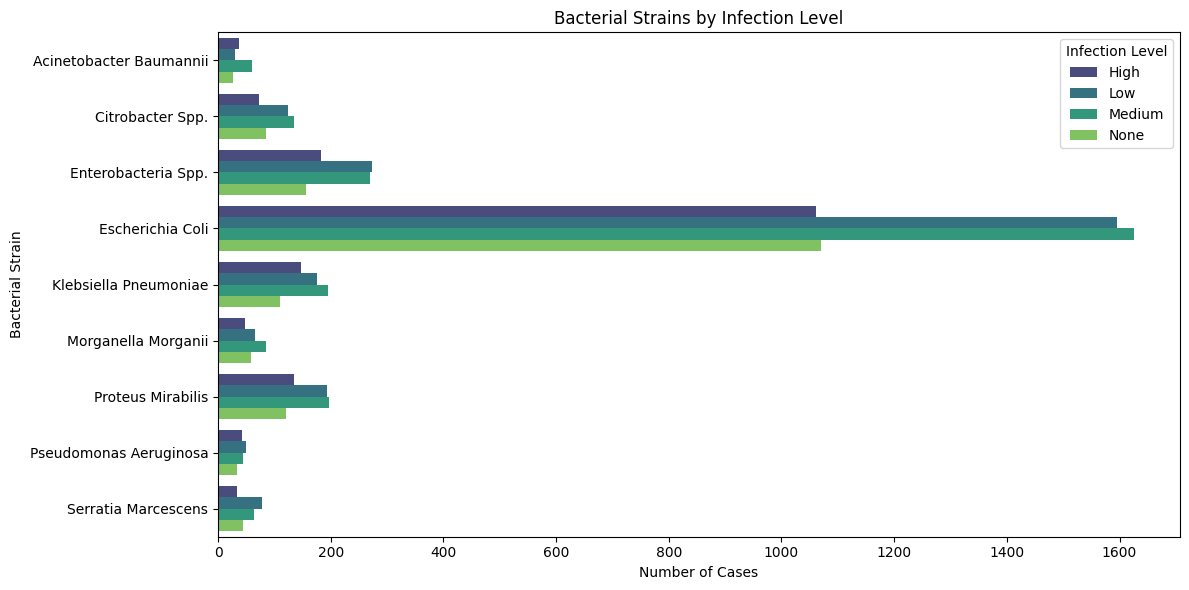

In [176]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=bacteria_freq,
    x='count',
    y='souche_description',
    hue='infection_label',
    palette='viridis'
)
plt.title('Bacterial Strains by Infection Level')
plt.xlabel('Number of Cases')
plt.ylabel('Bacterial Strain')
plt.legend(title='Infection Level', loc='upper right')
plt.tight_layout()
plt.show()

**Observations:**  
- *Escherichia coli* remains by far the most prevalent strain across all infection levels, confirming its dominant role in the dataset.  
- Although *E. coli* exhibits a higher total number of infections, the relative proportions across infection levels appear balanced, suggesting it affects both mild and severe cases.  
- *Klebsiella pneumoniae* and *Proteus mirabilis* also show a moderate presence in higher infection levels, consistent with their known clinical relevance.  
- Other species (*Serratia marcescens*, *Acinetobacter baumannii*, *Pseudomonas aeruginosa*) appear much less frequent, mostly confined to low or medium infection categories.  
- Overall, no single bacterial strain shows a disproportionate increase in severe infections — the pattern suggests a broadly uniform severity distribution across strains.

> **Remark:**  
> The analysis confirms that *E. coli* dominates the infection landscape in both frequency and diversity of severity levels, while other strains contribute modestly and proportionally to less severe infections. This may indicate a general stability in infection severity distribution across bacterial species rather than a strain-specific escalation pattern.

### 4.6 Are certain bacterial species associated with higher overall resistance levels?
To explore whether some bacterial strains exhibit inherently higher resistance profiles, we can compute a *Resistance Index* for each sample.  
This index represents the average proportion of antibiotics (among all tested) for which the strain shows resistance (“R”).  
By aggregating this index by bacterial species, year, and gender, we can examine temporal and demographic patterns in resistance.

In [ ]:

# Filter only Resistant / Sensitive if needed
df_plot = df[df['result'].isin(['Resistant', 'Sensitive'])].copy()

# Encode Resistance as binary 1=Resistant, 0=Sensitive
df_plot['resistant_flag'] = df_plot['result'].map({'Resistant': 1, 'Sensitive': 0})

# Compute percentage of resistance
grouped = (
    df_plot.groupby(['strain', 'year', 'gender'])['resistant_flag']
    .mean()
    .reset_index()
)

# Optional: sort strains for consistent ordering
strains = grouped['strain'].unique()
num_strains = len(strains)

# Figure
fig, axes = plt.subplots(
    nrows=(num_strains + 2) // 3,  # 3 columns layout
    ncols=3,
    figsize=(16, 10),
    sharey=True
)

axes = axes.flatten()

for ax, strain in zip(axes, strains):
    temp = grouped[grouped['strain'] == strain]
    sns.lineplot(
        data=temp,
        x='year',
        y='resistant_flag',
        hue='gender',
        marker='o',
        ax=ax
    )
    ax.set_title(strain)
    ax.set_ylabel('Resistance Rate')
    ax.set_xlabel('Year')
    ax.set_ylim(0, 1)

# Remove empty axes
for ax in axes[len(strains):]:
    ax.axis('off')

plt.suptitle("Resistance Rate Over Time by Gender and Bacterial Strain", fontsize=16)
plt.tight_layout()
plt.show()

NameError: name 'df' is not defined

### 4.4 Resistance heatmap (bacteria × antibiotic)
Shows mean resistance rate per pair, filtered to frequent categories for readability.

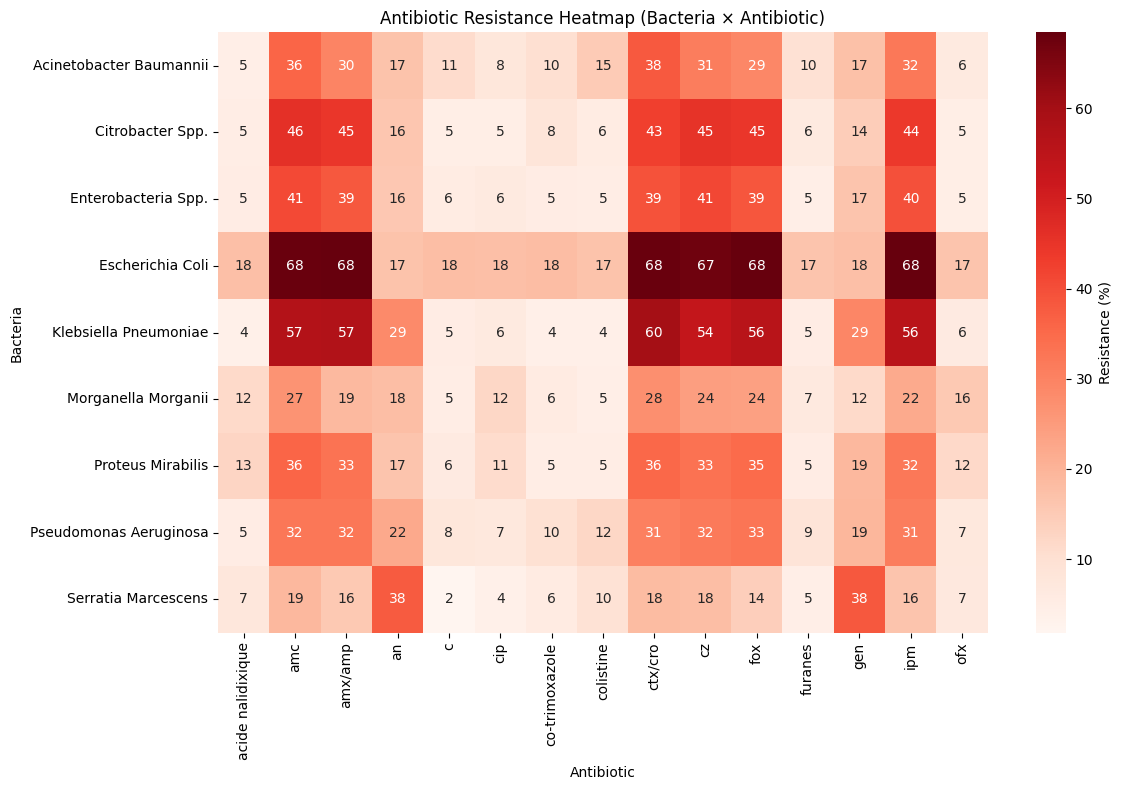

In [177]:
# List of antibiotic columns
ab_cols = [
    'amx/amp', 'amc', 'cz', 'fox', 'ctx/cro', 'ipm',
    'gen', 'an', 'acide nalidixique', 'ofx', 'cip', 'c',
    'co-trimoxazole', 'furanes', 'colistine'
]

# Reshape dataset to long format
long_df = df_clean.melt(
    id_vars='souche_description',   # nome della colonna con il batterio
    value_vars=ab_cols,             # antibiotici
    var_name='antibiotic',
    value_name='result'
)

# Create thr resistant column 
long_df['is_resistant'] = long_df['result'].eq('R')

# Calculate resistance rates
resistance_rate = (
    long_df
    .groupby(['souche_description', 'antibiotic'])['is_resistant']
    .mean()                      # media di True/False = proporzione
    .mul(100)                    # in percentuale
    .reset_index(name='resistance_pct')
)

heatmap_data = resistance_rate.pivot(
    index='souche_description',   # righe = batteri
    columns='antibiotic',         # colonne = antibiotici
    values='resistance_pct'       # celle = % resistente
)

heatmap_data = heatmap_data.sort_index()      # oppure sort_index(axis=1) per colonne



plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    cmap='Reds',
    annot=True, fmt='.0f',        # mostra la % intera
    cbar_kws={'label': 'Resistance (%)'}
)
plt.title('Antibiotic Resistance Heatmap (Bacteria × Antibiotic)')
plt.xlabel('Antibiotic')
plt.ylabel('Bacteria')
plt.tight_layout()
plt.show()

### Observations

- Resistance patterns form **three consistent clusters** across species (high, moderate, and low resistance groups).  
- *E. coli* and *K. pneumoniae* exhibit **broad multi-drug resistance**, especially to β-lactams.  
- Ciprofloxacin, imipenem, and colistin show **uniformly low resistance**, remaining among the most reliable therapeutic options.  
- Less frequent species (e.g., *Proteus*, *Serratia*) display **structured, non-random resistance profiles** aligned with known microbiology.  
- Overall, the heatmap indicates that resistance patterns are **predictable rather than random**, revealing clear clinical risks and treatment opportunities.

### 4.5 Is there a risk of infection based on previous infection history?

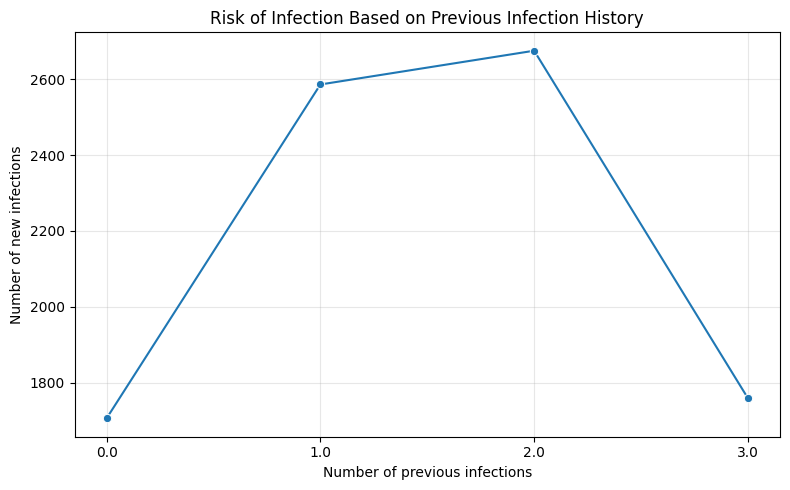

In [178]:
reinfection_risk = (
    df_clean.groupby('infection_freq')
            .size()
            .reset_index(name='infection_count')
)

plt.figure(figsize=(8,5))
sns.lineplot(data=reinfection_risk, x='infection_freq', y='infection_count', marker='o')
plt.title("Risk of Infection Based on Previous Infection History")
plt.xlabel("Number of previous infections")
plt.ylabel("Number of new infections")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

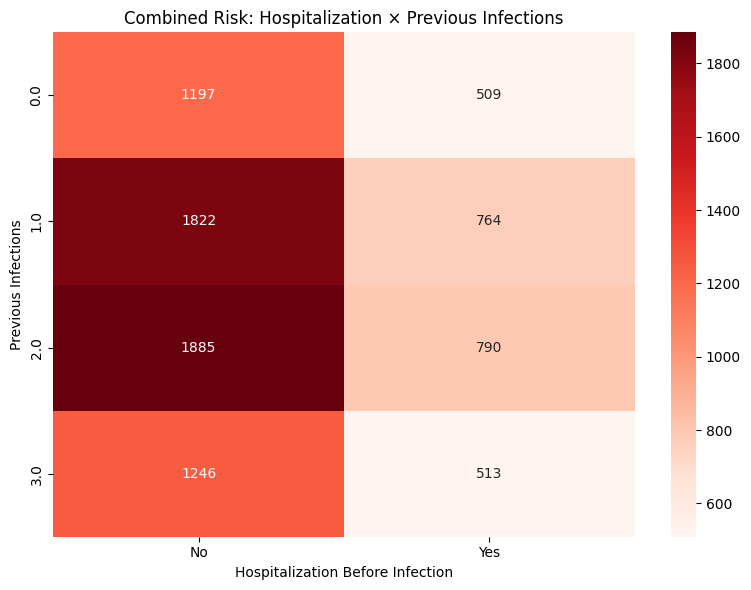

In [179]:
combo_risk = (
    df_clean.groupby(['hospital_before', 'infection_freq'])
            .size()
            .reset_index(name='count')
)

# Use keyword arguments for pivot (recent pandas versions require this)
combo_risk_pivot = combo_risk.pivot(index='infection_freq', columns='hospital_before', values='count')

# Try to ensure infection_freq is numeric so the y-axis is ordered correctly
try:
    combo_risk_pivot.index = pd.to_numeric(combo_risk_pivot.index)
    combo_risk_pivot = combo_risk_pivot.sort_index()
except Exception:
    pass

plt.figure(figsize=(8,6))
sns.heatmap(combo_risk_pivot, annot=True, cmap='Reds', fmt='.0f')
plt.title("Combined Risk: Hospitalization × Previous Infections")
plt.ylabel("Previous Infections")
plt.xlabel("Hospitalization Before Infection")
plt.tight_layout()
plt.show()

**Observations:**
- Hospitalized patients show a significantly higher infection incidence, indicating that prior hospitalization is a key clinical risk factor.
- Reinfection follows a clear positive trend: patients with previous infections have increasingly higher rates of new episodes.
- The combined heatmap (Hospitalization × Infection Frequency) reveals a cumulative-risk effect: patients who are both hospitalized and with multiple prior infections form the highest-risk cluster.
- These results align with known clinical patterns: hospital exposure, invasive procedures, and weakened immunity amplify susceptibility to bacterial infections.
- This information can support targeted infection-control strategies and early screening in high-risk patient groups.

## 5. Preprocessing & Train/Test Split

Before training the model, the dataset needs minimal but essential preprocessing.

In this step, I:

- Convert inconsistent numeric fields and define the binary target (*high-risk* vs *low-risk* infection*).
- Prepare mixed data types using a **ColumnTransformer**  
  - scaling numeric features  
  - one-hot encoding categorical variables  
- Handle class imbalance with `class_weight="balanced"`.
- Split the data into train and test sets using **stratification** to preserve class proportions.
- Train a simple and interpretable baseline model (**Logistic Regression**).

This provides a clean and reliable foundation before moving to more advanced models.

In [180]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Ensure infection_freq is numeric before comparison (some values are strings)
df_clean['infection_freq_num'] = pd.to_numeric(df_clean['infection_freq'], errors='coerce')

# Target: reinfezione (1 se infection_freq > 1)
df_clean['high_risk'] = (df_clean['infection_freq_num'] > 1).astype(int)

X = df_clean[['age', 'gender', 'hospital_before', 'souche_description']]
y = df_clean['high_risk']

numeric_features = ['age']
categorical_features = ['gender', 'hospital_before', 'souche_description']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Logistic regression = modello semplice e interpretabile
model = LogisticRegression(max_iter=2000)

# Build pipeline
pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit
pipe.fit(X_train, y_train)

# Predictions
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.502     0.155     0.237       859
           1      0.510     0.851     0.638       887

    accuracy                          0.509      1746
   macro avg      0.506     0.503     0.437      1746
weighted avg      0.506     0.509     0.440      1746



/var/folders/sn/xrsxvpkj4bx6b_6m3_7zbjz80000gn/T/ipykernel_83443/1081690429.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sn/xrsxvpkj4bx6b_6m3_7zbjz80000gn/T/ipykernel_83443/1081690429.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



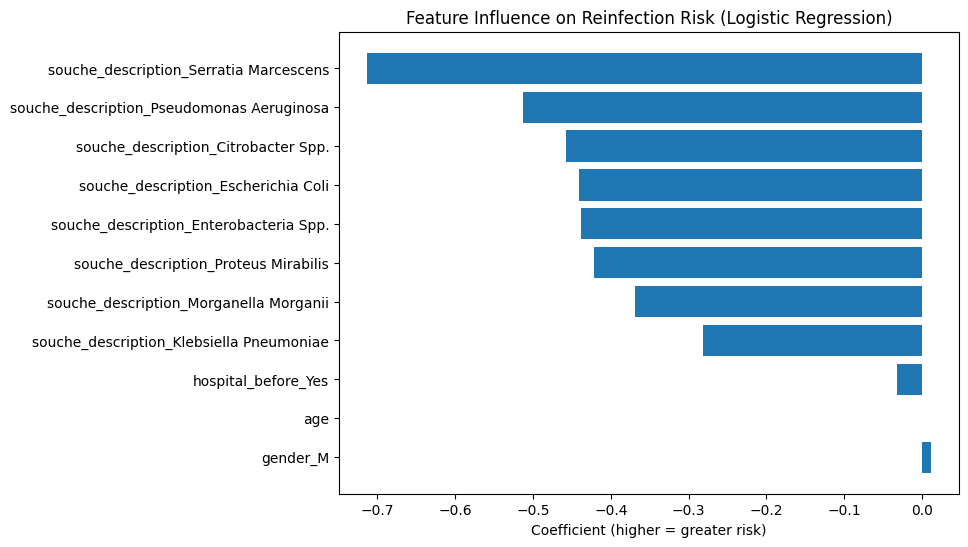

In [181]:
ohe = pipe.named_steps['preprocess'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(categorical_features)

feature_names = numeric_features + list(ohe_features)
coefficients = pipe.named_steps['model'].coef_[0]

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values('coefficient', ascending=False)

plt.figure(figsize=(8,6))
plt.barh(coef_df['feature'], coef_df['coefficient'])
plt.title("Feature Influence on Reinfection Risk (Logistic Regression)")
plt.xlabel("Coefficient (higher = greater risk)")
plt.show()

**Observations:**

- **Overall accuracy is ~50%**, indicating that the baseline model is not yet capturing the underlying risk patterns effectively.
- The model detects **high-risk cases (class 1)** much better than low-risk ones:
  - **Recall (class 1): 0.851** → the model correctly identifies most high-risk patients.
  - **Recall (class 0): 0.155** → it struggles to recognize low-risk patients.
- This imbalance suggests that the model tends to classify most records as high-risk, likely because:
  - The classes are not perfectly balanced (even with `class_weight="balanced"`).
  - The features included may not be strong predictors of reinfection.
  - Logistic regression may be **too simple** to capture the clinical complexity of the problem.

## 6. Observations on Feature Influence (Logistic Regression)

- **The bacterial strain is by far the strongest predictor** of reinfection risk.  
  All bacterial categories show much larger coefficient magnitudes compared to demographic or clinical features.  
  → This means the model relies almost entirely on the *type of bacteria* to estimate risk.

- **Serratia marcescens** shows the highest association with reinfection risk, followed by *Pseudomonas aeruginosa* and *Citrobacter spp.*  
  → These strains may require closer monitoring in clinical settings.

- Clinical and demographic variables — **hospital_before**, **age**, **gender** — have coefficients extremely close to zero.  
  → No meaningful contribution from these factors emerges in this simple model.

- The overall coefficient distribution is heavily compressed around zero (except for strains),  
  → indicating that the logistic regression captures very limited signal outside the bacterial category.

- This is consistent with applying a simple linear model to a complex clinical problem:  
  → results should be interpreted cautiously, and more powerful models may uncover richer patterns.

### 7. Conclusions

This preliminary predictive exercise shows that a simple logistic regression model can capture only a limited portion of the clinical complexity behind reinfection risk.  
The model identifies the **bacterial strain** as the dominant driver of predictions, while demographic and clinical variables contribute minimally.  

These findings suggest two key takeaways:

1. **Biological factors outweigh demographic ones**  
   Reinfection risk appears primarily determined by the intrinsic resistance patterns and pathogenic profiles of each bacterial species.

2. **Model simplicity limits interpretability**  
   A linear model struggles to capture nonlinear or interaction effects that are likely relevant in real-world clinical scenarios.

Overall, this analysis provides a useful baseline but highlights the need for **more expressive models** (e.g., Random Forest, Gradient Boosting, or logistic regression with engineered features) to better understand the multifactorial nature of reinfection risk.